In [1]:
# Import libraries
%matplotlib inline

import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
import pysal as ps

sns.set(style="whitegrid")

/Users/shannagreathouse/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Import data
broker_data = 'data/Brokered2018_zipcodes.csv'
coord = 'data/states.json'


In [3]:
# Read data
broker = pd.read_csv(broker_data)
broker.head()

/Users/shannagreathouse/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Order #,Leg #,Start Date,Agent Office,Cust ID,Customer,Carrier ID,Carrier,Origin City,OriginState,Destination City,Destination State,Brokered Revenue,Carrier Pay,Brokered Margin,Brokered Margin %,Booking Agent ID,Booking Agent
0,1361713,1349039,8/15/18,1,AMNP,AMNP,43708,43708,San Antonio,Texas,Palmyra,Wisconsin,2500,2400,100.0,4.00%,KAILA,1
1,1501026,1542730,1/30/18,1,AMNP,AMNP,442007,442007,Hammond,Indiana,Denver,Colorado,3050,2950,100.0,3.27%,KAILA,1
2,1518714,1567360,1/5/18,1,AMNP,AMNP,971955,971955,Denver,Colorado,Meridian,Idaho,1200,1200,0.0,0.00%,ZABCA,2
3,1538821,1595101,4/2/18,1,AMNP,AMNP,355478,355478,Jewett,Texas,Hartford,South Dakota,2000,1900,100.0,5.00%,KAILA,1
4,1601007,1680031,8/22/18,1,AMNP,AMNP,184749,184749,Bismarck,North Dakota,Marion,Ohio,2300,2200,100.0,4.34%,KAILA,1


In [4]:
broker['Start Date'] =  pd.to_datetime(broker['Start Date'])

In [5]:
print(broker['Start Date'])

0        2018-08-15
1        2018-01-30
2        2018-01-05
3        2018-04-02
4        2018-08-22
            ...    
213739   2021-05-28
213740   2021-05-28
213741   2021-05-31
213742   2021-05-31
213743   2021-05-31
Name: Start Date, Length: 213744, dtype: datetime64[ns]


In [6]:
# Find the max date in the data set for rolling 12 month
endDate = broker['Start Date'].max()
endDate

Timestamp('2021-05-31 00:00:00')

In [7]:
# Rolling date start point
startDate = endDate - pd.DateOffset(years=1)
startDate

Timestamp('2020-05-31 00:00:00')

In [8]:
#filter out data prior to start date to have rolling 12 months; rename origin column to state
filteredBroker = broker.loc[(broker['Start Date'] >= startDate)]
filteredBroker.rename(columns = {'OriginState':'NAME'}, inplace = True)


#Check data types to make sure margin can be integers
for col in filteredBroker.columns:
    print(col)

filteredBroker

print(filteredBroker.dtypes)

Order #
Leg #
Start Date
Agent Office
Cust ID
Customer
Carrier ID
Carrier
Origin City
NAME
Destination City
Destination State
Brokered Revenue
Carrier Pay
Brokered Margin
Brokered Margin %
Booking Agent ID
Booking Agent
Order #                       int64
Leg #                         int64
Start Date           datetime64[ns]
Agent Office                  int64
Cust ID                      object
Customer                     object
Carrier ID                   object
Carrier                      object
Origin City                  object
NAME                         object
Destination City             object
Destination State            object
Brokered Revenue             object
Carrier Pay                  object
Brokered Margin             float64
Brokered Margin %            object
Booking Agent ID             object
Booking Agent                 int64
dtype: object


/Users/shannagreathouse/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [42]:
# Filter out contracted offices
agents = [1, 7, 8, 10, 18, 20, 21, 22, 23, 24, 27, 29,30,5,6,17]

#Filter out sister company offices
sister_agents = [5, 6, 17]

inverse_boolean_series = ~filteredBroker['Agent Office'].isin(agents)
filteredBroker = filteredBroker[inverse_boolean_series]
filteredBroker

,Order #,Leg #,Start Date,Agent Office,Cust ID,Customer,Carrier ID,Carrier,Origin City,NAME,Destination City,Destination State,Brokered Revenue,Carrier Pay,Brokered Margin,Brokered Margin %,Booking Agent ID,Booking Agent
145956,2079035,2271393,2020-06-22,14,NPPDU,NPPDU,CTLO,CTLO,Lafayette,Indiana,Jefferson,Wisconsin,757.55,750,7.55,0.99%,MASNIC,25
148015,2084391,2278351,2020-05-31,12,WWBO,WWBO,870923,870923,Platteville,Colorado,Ontario,California,1601.22,1250,351.22,21.93%,APOST,36
148521,2085776,2280307,2020-06-02,14,ALNA,ALNA,766974,766974,Greenwood,Wisconsin,Buffalo,New York,3365,3200,165.00,4.90%,GEBER,26
148580,2085886,2280448,2020-06-05,14,CONELP,CONELP,179534,179534,Kaukauna,Wisconsin,Maple Grove,Minnesota,673.19,450,223.19,33.15%,MASNIC,25
148605,2085949,2280521,2020-06-08,14,CONELP,CONELP,157540,157540,Kaukauna,Wisconsin,Maple Grove,Minnesota,677.28,600,77.28,11.41%,PEANI,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213738,2341420,2586069,2021-05-27,16,CHICHA,CHICHA,770152,770152,New Castle,Delaware,Wilmington,Delaware,143.96,0,143.96,100.00%,UNKNOWN,6
213740,2347760,2593593,2021-05-28,16,CHICHA,CHICHA,770152,770152,New Castle,Delaware,Wilmington,Delaware,143.96,0,143.96,100.00%,UNKNOWN,6
213741,2347761,2593594,2021-05-31,16,CHICHA,CHICHA,770152,770152,New Castle,Delaware,Wilmington,Delaware,143.96,0,143.96,100.00%,UNKNOWN,6
213742,2347762,2593595,2021-05-31,16,CHICHA,CHICHA,770152,770152,New Castle,Delaware,Wilmington,Delaware,143.96,0,143.96,100.00%,UNKNOWN,6


In [43]:
# Numeric variables maintained
varis = ['Brokered Margin']
varis_2 = ['Order #']

In [44]:
#Group data by state
states = filteredBroker.groupby('NAME')[varis].mean()
load_count = filteredBroker.groupby('NAME')[varis_2].count()

# Combine data sets
states = pd.merge(states, load_count, on=["NAME"])

states

,Brokered Margin,Order #
NAME,,
Alabama,354.704333,60
Arizona,483.687549,102
Arkansas,425.534454,238
California,294.496853,1309
Colorado,288.036244,868
Connecticut,268.577147,382
Delaware,242.082056,12337
Florida,279.243000,50
Georgia,387.423054,298


In [45]:
statesct = filteredBroker.groupby(['NAME']).describe().loc[:,(slice(None),['count'])]
#statesct

In [46]:
#Find max smallest region volume (eg state) for limits
max_state_volume = states['Order #'].max()
max_state_volume
total_loads = filteredBroker[varis_2].count()
max_state_share = max_state_volume / total_loads
max_state_share

Order #    0.329769
dtype: float64

In [47]:
#Max Load Volume in a region
volume_limit = 0.4
max_load = total_loads*volume_limit
max_load

Order #    14964.4
dtype: float64

In [48]:
#Code placeholder to set threshold and add as variable
#n_rev = lst.groupby('zipcode')\
#           .sum()\
#           ['number_of_reviews']\
#           .rename(lambda x: str(int(x)))\
 #          .reindex(zrt['zipcode'])
#thr = np.round(0.1 * n_rev.sum())
#thr

In [49]:
#Group by customers and carriers and convert to binary
types = pd.get_dummies(filteredBroker['Customer'])
region_types = types.join(filteredBroker['NAME'])\
                  .groupby('NAME')\
                  .sum()
types_2 = pd.get_dummies(filteredBroker['Carrier'])
region_types = types_2.join(filteredBroker['NAME'])\
                  .groupby('NAME')\
                  .sum()
region_types_pct = (region_types * 100.).div(region_types.sum(axis=1), axis=0)
region_types_pct.info()
region_types_pct

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Alabama to Wisconsin
Columns: 7717 entries, 008484A to ZTLMI
dtypes: float64(7717)
memory usage: 2.8+ MB


,008484A,011099A,032654A,042077A,056299A,058054A,068781A,072462A,1000145,1000319,...,WTIMO,WTIWA,YTSDA,YTTEL,ZBTPA,ZSOM,ZTHA,ZTHO,ZTKI,ZTLMI
NAME,,,,,,,,,,,,,,,,,,,,,
Alabama,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Arizona,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Arkansas,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
California,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Colorado,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.115207,0.000000,0.000000,0.000000,0.000000,0.000000
Connecticut,0.000000,0.26178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Delaware,0.000000,0.00000,0.008106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.258815,0.000000,0.000000
Florida,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Georgia,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [50]:
# Combine data sets
region_props = pd.merge(states, region_types, on=["NAME"])

In [51]:
#Scale not applicable because only 1 numeric variable
#db = pd.DataFrame(\
 #                scale(region_props), \
  #               index=region_props.index, \
   #              columns=region_props.columns)\
    #   .rename(lambda x: str(int(x)))
db = region_props

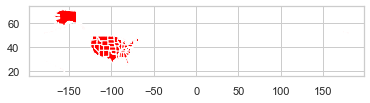

In [52]:
# bring in geojson dataframe
usMap = gpd.read_file(coord)
usMap.plot(color='red');

In [53]:
# match geojson dataframe and broker_data on 'state'
statedb = usMap[['geometry', 'STATE', 'NAME']].join(db, on='NAME')\
                                         .dropna()

In [54]:
#Optimal Cluster Calculations
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    #km.fit(X)
    km = km.fit(statesct) #count of Origin state
    Sum_of_squared_distances.append(km.inertia_)

In [55]:
Sum_of_squared_distances

[847012909.7872342,
 165954529.67391306,
 43337005.86080585,
 18565502.88461539,
 8409861.071428573,
 4315600.0487013,
 2621651.8981481483,
 1393810.1666666663,
 774191.7678571428]

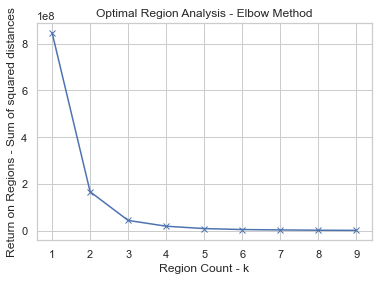

In [56]:
#optimal clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Region Count - k')
plt.ylabel('Return on Regions - Sum of squared distances')
plt.title('Optimal Region Analysis - Elbow Method')
plt.savefig('Elbow Method')

In [79]:
#Cluster in specfic groups
cluster_count = 5
km5 = cluster.KMeans(n_clusters=cluster_count)

In [80]:
# Fit to data
km5cls = km5.fit(statedb.drop(['geometry', 'NAME'], axis=1).values)

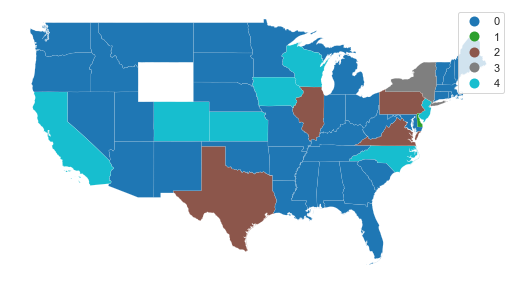

In [81]:
# Map clusters
f, ax = plt.subplots(1, figsize=(9, 9))

statedb.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()
statedb['km5cls'] = km5cls.labels_
plt.savefig('Regions')

In [82]:
# Region sizes
k5sizes = statedb.groupby('km5cls').size()
k5sizes


km5cls
0    34
1     1
2     4
3     1
4     7
dtype: int64

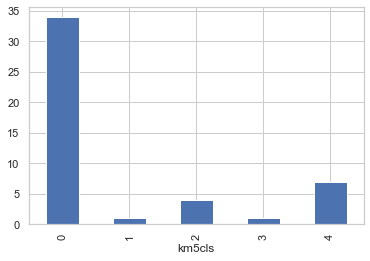

In [83]:
#Visualize attributes and mix
_ = k5sizes.plot.bar()

In [84]:
k5sizes_df = statedb.groupby('km5cls').size().to_frame(name = 'State Count')
k5sizes_df

,State Count
km5cls,
0,34
1,1
2,4
3,1
4,7


In [85]:
statedb

,geometry,STATE,NAME,Brokered Margin,Order #,008484A,011099A,032654A,042077A,056299A,...,WTIWA,YTSDA,YTTEL,ZBTPA,ZSOM,ZTHA,ZTHO,ZTKI,ZTLMI,km5cls
0,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ...",23,Maine,168.181818,22.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ...",25,Massachusetts,208.732533,75.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,"MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ...",26,Michigan,374.542619,252.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,"POLYGON ((-104.05770 44.99743, -104.25015 44.9...",30,Montana,668.600000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,"POLYGON ((-114.05060 37.00040, -114.04999 36.9...",32,Nevada,1038.232667,30.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,"POLYGON ((-75.52684 39.65571, -75.52634 39.656...",34,New Jersey,275.390387,905.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
6,"MULTIPOLYGON (((-71.94356 41.28668, -71.92680 ...",36,New York,339.061896,4324.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3
7,"MULTIPOLYGON (((-82.60288 36.03983, -82.60074 ...",37,North Carolina,312.165107,701.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4
8,"MULTIPOLYGON (((-82.81349 41.72347, -82.81049 ...",39,Ohio,248.431315,464.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,"POLYGON ((-75.41504 39.80179, -75.42804 39.809...",42,Pennsylvania,335.645870,2593.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,282.0,0.0,0.0,2


In [86]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
Avg_Margin = statedb.groupby('km5cls')['Brokered Margin'].mean().to_frame(name = 'Mean Margin').reset_index()
# Transpose the table and print it rounding each value
# to three decimals
Avg_Margin = Avg_Margin.round(3)

Avg_Margin

,km5cls,Mean Margin
0,0,376.101
1,1,242.082
2,2,352.715
3,3,339.062
4,4,346.338


In [87]:
Load_Volume = statedb.groupby('km5cls')['Order #'].sum().to_frame(name = 'Annual Load Volume').reset_index()
Load_Volume

,km5cls,Annual Load Volume
0,0,5117.0
1,1,12337.0
2,2,8752.0
3,3,4324.0
4,4,6640.0


In [88]:
#Merge tables
region_desc = pd.merge(k5sizes_df, Avg_Margin, how='left', on='km5cls')
regiondesc = pd.merge(region_desc, Load_Volume, how='left', on='km5cls').rename(columns = {'km5cls':'Region'}, inplace = False)
regiondesc

,Region,State Count,Mean Margin,Annual Load Volume
0,0,34,376.101,5117.0
1,1,1,242.082,12337.0
2,2,4,352.715,8752.0
3,3,1,339.062,4324.0
4,4,7,346.338,6640.0


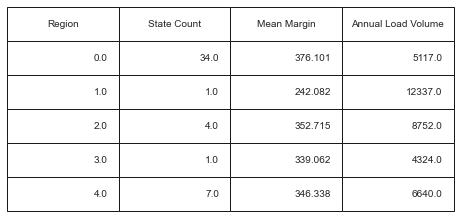

In [89]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(True)
    mpl_table.set_fontsize(font_size)

render_mpl_table(regiondesc, header_columns=0, col_width=2.0)
plt.savefig('Region Properties')